## 1. Environment Setup, Imports, and Reproducibility

This cell prepares the execution environment for the experiment. It mounts Google Drive
to access the dataset, imports all required libraries for data processing, machine learning,
and transformer-based models, and sets random seeds to ensure reproducibility of results.

Reproducibility is critical in experimental machine learning research so that results can
be reliably replicated. The device (CPU or GPU) is automatically detected to enable efficient
training of large language models.


In [ ]:
# Mount Google Drive to access dataset stored in Drive
from google.colab import drive
drive.mount("/content/drive")

# Standard Python libraries
import ast                 # For safely parsing structured text fields
import random              # For controlling randomness
import numpy as np         # Numerical operations
import pandas as pd        # Data handling and analysis
import torch               # Deep learning framework

# Utility imports
from dataclasses import dataclass   # For structured configuration objects
from typing import Dict, Tuple      # Type hints for clarity

# PyTorch data utilities
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW       # Optimizer commonly used for transformers

# Scikit-learn utilities for baseline models and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Hugging Face Transformers library
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    get_linear_schedule_with_warmup
)

# -----------------------------
# Reproducibility
# -----------------------------
# Fix random seeds to ensure consistent and reproducible results
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Ensure reproducibility when using GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Automatically select GPU if available, otherwise fall back to CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Mounted at /content/drive
Device: cuda


## 2. Dataset Loading and Aspect-Level Sentiment Extraction

This cell loads the SEntFiN v1.1 financial news dataset from Google Drive and
prepares it for aspect-based sentiment analysis (ABSA). Each news headline
contains structured sentiment annotations in dictionary form, mapping a
financial entity (aspect) to its sentiment label.

The dataset is transformed into sentence–aspect–sentiment triples, which
serve as the core input format for both baseline machine learning models
and fine-tuned transformer-based models.


In [ ]:
# Path to the SEntFiN v1.1 dataset stored in Google Drive
DATA_PATH = "/content/drive/MyDrive/SEntFiN-v1.1.csv"

# Load the dataset into a pandas DataFrame
df_raw = pd.read_csv(DATA_PATH)

def extract_aspect_sentiment(decision_str: str) -> Tuple[str, str]:
    """
    Extract the financial entity (aspect) and its corresponding sentiment label
    from the structured 'Decisions' field.

    Example:
    '{"SpiceJet": "neutral"}' → aspect='SpiceJet', sentiment='neutral'
    """
    # Safely parse the string representation of a dictionary
    decision_dict = ast.literal_eval(decision_str)

    # Extract the first (and only) entity–sentiment pair
    aspect = list(decision_dict.keys())[0]
    sentiment = list(decision_dict.values())[0]

    return aspect, sentiment

# Rename the headline column for clarity and consistency
df = df_raw.rename(columns={"Title": "sentence"}).copy()

# Apply aspect–sentiment extraction to each row
df[["aspect", "sentiment"]] = df["Decisions"].apply(
    lambda x: pd.Series(extract_aspect_sentiment(x))
)

# Keep only relevant columns and remove any incomplete records
df = df[["sentence", "aspect", "sentiment"]].dropna().reset_index(drop=True)

# Display a preview of the processed dataset
df.head()


,sentence,aspect,sentiment
0,SpiceJet to issue 6.4 crore warrants to promoters,SpiceJet,neutral
1,MMTC Q2 net loss at Rs 10.4 crore,MMTC,neutral
2,"Mid-cap funds can deliver more, stay put: Experts",Mid-cap funds,positive
3,Mid caps now turn into market darlings,Mid caps,positive
4,"Market seeing patience, if not conviction: Pra...",Market,neutral


## 3. Model-Specific Input Construction and Train–Test Split

This cell prepares model-specific text inputs by combining the news headline
(sentence) with the target financial entity (aspect) using separator tokens
appropriate to each transformer architecture. This ensures that each model
receives input in a format aligned with its pre-training.

Sentiment labels are encoded numerically, and the dataset is split into
training and testing subsets using stratified sampling to preserve class
distribution. These splits are used consistently across all models to ensure
fair comparison.


In [ ]:
# -------------------------------------------------
# Model-specific input formatting
# -------------------------------------------------
# FinBERT expects BERT-style separation between sentence and aspect
df["text_finbert"] = df["sentence"] + " [SEP] " + df["aspect"]

# RoBERTa uses </s></s> as the sentence-pair separator token
df["text_roberta"] = df["sentence"] + " </s></s> " + df["aspect"]

# Encode sentiment labels (negative, neutral, positive) as integers
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["sentiment"])

# Display the mapping of sentiment classes to numeric labels
print("Sentiment classes:", label_encoder.classes_)

# -------------------------------------------------
# Train–test split
# -------------------------------------------------
# Split indices into training and testing sets with stratification
# to preserve sentiment class distribution
train_idx, test_idx = train_test_split(
    df.index,
    test_size=0.2,
    random_state=SEED,
    stratify=df["label"]
)

# Create training and testing DataFrames
train_df = df.loc[train_idx].reset_index(drop=True)
test_df  = df.loc[test_idx].reset_index(drop=True)

# Extract numeric labels for model training and evaluation
y_train = train_df["label"].values
y_test  = test_df["label"].values


Sentiment classes: ['negative' 'neutral' 'positive']


## 4. Baseline Model: TF-IDF + Logistic Regression

This cell implements a traditional machine learning baseline using TF-IDF
features and a Logistic Regression classifier. The baseline provides a
non-transformer point of comparison to assess whether fine-tuned large
language models offer a meaningful performance improvement.

The same train–test split is used to ensure a fair and controlled comparison
with transformer-based models.


In [ ]:
def compute_metrics(y_true, y_pred) -> Dict[str, float]:
    """
    Compute standard classification metrics used for model evaluation.
    Weighted averaging is applied to account for class imbalance.
    """
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_w": precision_score(
            y_true, y_pred, average="weighted", zero_division=0
        ),
        "recall_w": recall_score(
            y_true, y_pred, average="weighted", zero_division=0
        ),
        "f1_w": f1_score(
            y_true, y_pred, average="weighted", zero_division=0
        ),
    }

# -------------------------------------------------
# TF-IDF feature extraction
# -------------------------------------------------
# Convert text into a sparse TF-IDF representation using unigrams and bigrams
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit TF-IDF on training data and transform both splits
X_train_tfidf = tfidf.fit_transform(train_df["text_finbert"])
X_test_tfidf  = tfidf.transform(test_df["text_finbert"])

# -------------------------------------------------
# Logistic Regression baseline
# -------------------------------------------------
# Train a Logistic Regression classifier on TF-IDF features
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tfidf, y_train)

# Generate predictions on the test set
pred_lr = logreg.predict(X_test_tfidf)

# Compute evaluation metrics for the baseline model
metrics_lr = compute_metrics(y_test, pred_lr)

# Display baseline performance
print("Logistic Regression:", metrics_lr)


Logistic Regression: {'accuracy': 0.7787075778707578, 'precision_w': 0.7820611949334282, 'recall_w': 0.7787075778707578, 'f1_w': 0.7782594507031825}


## 5. Custom PyTorch Dataset for Transformer Models

This cell defines a custom PyTorch `Dataset` class used to prepare inputs for
transformer-based models. It handles tokenisation, padding, truncation, and
label alignment, allowing the data to be efficiently loaded in batches during
training and evaluation.

Using a custom dataset ensures compatibility with Hugging Face tokenizers and
enables scalable training via PyTorch `DataLoader`.


In [ ]:
class TextDataset(Dataset):
    """
    Custom PyTorch Dataset for transformer-based text classification.
    This dataset tokenizes input text and returns tensors required
    by Hugging Face models.
    """

    def __init__(self, texts, labels, tokenizer, max_len=128):
        # Store raw texts and labels as lists for indexing
        self.texts = texts.tolist()
        self.labels = labels.tolist()

        # Tokenizer corresponding to the chosen transformer model
        self.tokenizer = tokenizer

        # Maximum sequence length for padding and truncation
        self.max_len = max_len

    def __len__(self):
        # Return total number of samples
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize a single text instance
        enc = self.tokenizer(
            self.texts[idx],
            padding="max_length",     # Pad sequences to fixed length
            truncation=True,          # Truncate sequences exceeding max_len
            max_length=self.max_len,
            return_tensors="pt"       # Return PyTorch tensors
        )

        # Return model-ready inputs and corresponding label
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


## 6. Training Configuration and Model Training Loop

This cell defines the training configuration and implements reusable training
and evaluation functions for transformer-based models. Hyperparameters such as
learning rate, batch size, number of epochs, and warm-up ratio are centralised
using a configuration object to ensure clarity and consistency across models.

A standard fine-tuning loop is implemented using the AdamW optimiser and a
linear learning rate scheduler with warm-up, following best practices for
training large language models.


In [ ]:
@dataclass
class TrainConfig:
    """
    Configuration class to store training hyperparameters.
    Centralising these values improves readability and reproducibility.
    """
    epochs: int = 3          # Number of fine-tuning epochs
    batch_size: int = 16     # Batch size for training and evaluation
    lr: float = 2e-5         # Learning rate for AdamW optimiser
    max_len: int = 128       # Maximum input sequence length
    warmup_ratio: float = 0.1  # Proportion of warm-up steps for the scheduler


def train_model(model, loader, cfg):
    """
    Fine-tune a transformer model using a standard training loop.
    """
    # Move model to the appropriate device (CPU or GPU)
    model.to(DEVICE)

    # Initialise the AdamW optimiser
    optimizer = AdamW(model.parameters(), lr=cfg.lr)

    # Total number of training steps
    total_steps = len(loader) * cfg.epochs

    # Linear learning rate scheduler with warm-up
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        int(cfg.warmup_ratio * total_steps),
        total_steps
    )

    # Training loop
    for epoch in range(cfg.epochs):
        model.train()
        epoch_loss = 0.0

        for batch in loader:
            # Reset gradients
            optimizer.zero_grad()

            # Forward pass with labels to compute loss
            out = model(
                input_ids=batch["input_ids"].to(DEVICE),
                attention_mask=batch["attention_mask"].to(DEVICE),
                labels=batch["labels"].to(DEVICE)
            )

            # Backpropagation
            out.loss.backward()

            # Optimiser and scheduler updates
            optimizer.step()
            scheduler.step()

            # Accumulate batch loss
            epoch_loss += out.loss.item()

        # Report average training loss for the epoch
        print(
            f"Epoch {epoch+1}/{cfg.epochs} | "
            f"Loss: {epoch_loss/len(loader):.4f}"
        )


@torch.no_grad()
def evaluate(model, loader):
    """
    Evaluate a fine-tuned transformer model on a held-out dataset.
    """
    model.eval()
    preds, true = [], []

    for batch in loader:
        # Forward pass without labels for prediction
        out = model(
            input_ids=batch["input_ids"].to(DEVICE),
            attention_mask=batch["attention_mask"].to(DEVICE)
        )

        # Select class with highest predicted probability
        preds.append(torch.argmax(out.logits, 1).cpu().numpy())
        true.append(batch["labels"].numpy())

    # Concatenate batch-level outputs
    return np.concatenate(preds), np.concatenate(true)


## 7. Fine-Tuning FinBERT for Aspect-Based Sentiment Analysis

This cell fine-tunes FinBERT, a domain-specific transformer model pre-trained
on financial text, for aspect-based sentiment classification. FinBERT is
particularly well-suited to this task due to its exposure to financial
terminology and discourse during pre-training.

The model is trained using the previously defined training loop and evaluated
on the held-out test set. Performance metrics are computed to enable comparison
with both the baseline model and other transformer-based models.


In [ ]:
# Initialise training configuration
cfg = TrainConfig()

# -------------------------------------------------
# Load FinBERT tokenizer and model
# -------------------------------------------------
# FinBERT is pre-trained on large-scale financial text
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert",
    num_labels=len(label_encoder.classes_)  # Number of sentiment classes
)

# -------------------------------------------------
# Create datasets for FinBERT
# -------------------------------------------------
# Use FinBERT-specific input formatting (sentence [SEP] aspect)
fin_train_ds = TextDataset(
    train_df["text_finbert"],
    y_train,
    finbert_tokenizer,
    cfg.max_len
)

fin_test_ds = TextDataset(
    test_df["text_finbert"],
    y_test,
    finbert_tokenizer,
    cfg.max_len
)

# -------------------------------------------------
# Create data loaders
# -------------------------------------------------
fin_train_loader = DataLoader(
    fin_train_ds,
    batch_size=cfg.batch_size,
    shuffle=True
)

fin_test_loader = DataLoader(
    fin_test_ds,
    batch_size=cfg.batch_size
)

# -------------------------------------------------
# Fine-tune FinBERT
# -------------------------------------------------
train_model(finbert_model, fin_train_loader, cfg)

# -------------------------------------------------
# Evaluate FinBERT performance
# -------------------------------------------------
fin_preds, fin_true = evaluate(finbert_model, fin_test_loader)
metrics_finbert = compute_metrics(fin_true, fin_preds)

# Display FinBERT evaluation results
print("FinBERT:", metrics_finbert)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Epoch 1/3 | Loss: 0.7256
Epoch 2/3 | Loss: 0.2873
Epoch 3/3 | Loss: 0.1615
FinBERT: {'accuracy': 0.8800557880055788, 'precision_w': 0.8799247746277279, 'recall_w': 0.8800557880055788, 'f1_w': 0.8799677216131719}


## 8. Fine-Tuning RoBERTa for Aspect-Based Sentiment Analysis

This cell fine-tunes RoBERTa, a general-purpose transformer model, for the
aspect-based sentiment analysis task. Unlike FinBERT, RoBERTa is not
domain-specific, allowing comparison between a financial-domain model and
a robust general-language model.

The same training configuration and evaluation procedure are used to ensure
a fair comparison with FinBERT and the baseline classifier.


In [ ]:
# -------------------------------------------------
# Load RoBERTa tokenizer and model
# -------------------------------------------------
# RoBERTa is a general-purpose transformer model
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(label_encoder.classes_)  # Number of sentiment classes
)

# -------------------------------------------------
# Create datasets for RoBERTa
# -------------------------------------------------
# Use RoBERTa-specific input formatting (sentence </s></s> aspect)
rob_train_ds = TextDataset(
    train_df["text_roberta"],
    y_train,
    roberta_tokenizer,
    cfg.max_len
)

rob_test_ds = TextDataset(
    test_df["text_roberta"],
    y_test,
    roberta_tokenizer,
    cfg.max_len
)

# -------------------------------------------------
# Create data loaders
# -------------------------------------------------
rob_train_loader = DataLoader(
    rob_train_ds,
    batch_size=cfg.batch_size,
    shuffle=True
)

rob_test_loader = DataLoader(
    rob_test_ds,
    batch_size=cfg.batch_size
)

# -------------------------------------------------
# Fine-tune RoBERTa
# -------------------------------------------------
train_model(roberta_model, rob_train_loader, cfg)

# -------------------------------------------------
# Evaluate RoBERTa performance
# -------------------------------------------------
rob_preds, rob_true = evaluate(roberta_model, rob_test_loader)
metrics_roberta = compute_metrics(rob_true, rob_preds)

# Display RoBERTa evaluation results
print("RoBERTa:", metrics_roberta)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Loss: 0.5326
Epoch 2/3 | Loss: 0.2575
Epoch 3/3 | Loss: 0.1694
RoBERTa: {'accuracy': 0.898651789865179, 'precision_w': 0.8992465623362876, 'recall_w': 0.898651789865179, 'f1_w': 0.8977453439833432}


## 9. Confusion Matrix for RoBERTa Predictions

This cell visualises the confusion matrix for the RoBERTa model on the test
dataset. The confusion matrix provides a class-wise breakdown of model
predictions, highlighting where the model performs well and where
misclassifications occur between sentiment classes.

This visualisation supports a more detailed interpretation of model behaviour
beyond aggregate evaluation metrics.


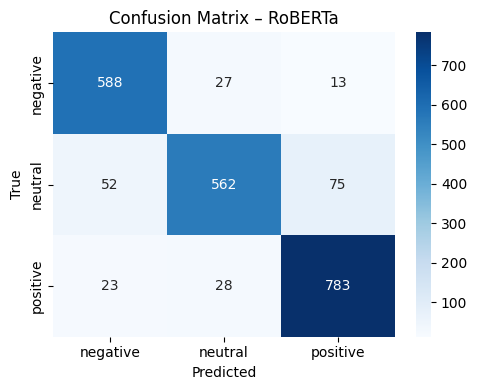

In [ ]:
# Compute confusion matrix using true and predicted labels
cm = confusion_matrix(rob_true, rob_preds)

# Create a heatmap for visual inspection of classification performance
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,                    # Display counts in each cell
    fmt="d",                       # Integer formatting
    cmap="Blues",                  # Colour scheme
    xticklabels=label_encoder.classes_,  # Predicted class labels
    yticklabels=label_encoder.classes_   # True class labels
)

# Axis labels and title for clarity
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – RoBERTa")

# Adjust layout to prevent label clipping
plt.tight_layout()
plt.show()


## 10. Comparative Performance Analysis Across Models

This cell compares the weighted F1-scores of the baseline model and the two
fine-tuned transformer models. Visual comparison highlights the performance
gains achieved by domain-specific and general-purpose large language models
over traditional machine learning approaches.

Using weighted F1-score ensures that class imbalance is taken into account
when comparing models.


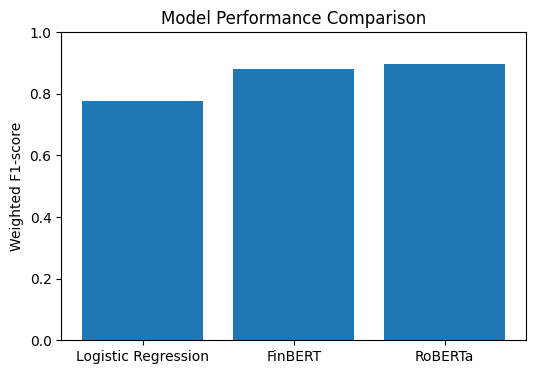

In [ ]:
# List of evaluated models for comparison
models = ["Logistic Regression", "FinBERT", "RoBERTa"]

# Extract weighted F1-scores for each model
f1_scores = [
    metrics_lr["f1_w"],
    metrics_finbert["f1_w"],
    metrics_roberta["f1_w"]
]

# Create a bar chart to compare model performance
plt.figure(figsize=(6, 4))
plt.bar(models, f1_scores)

# Label axes and set plot title
plt.ylabel("Weighted F1-score")
plt.title("Model Performance Comparison")

# Fix y-axis range for consistent interpretation
plt.ylim(0, 1)
plt.show()


## 11. Qualitative Error Analysis: Actual vs Predicted Sentiment

This cell performs a qualitative evaluation of the best-performing model by
comparing predicted sentiment labels with ground-truth labels for randomly
selected test examples. This analysis helps to identify common error patterns,
such as confusion between neutral and weakly positive or negative sentiments,
and provides insight into the model’s limitations beyond quantitative metrics.


In [ ]:
def decode_label(label_id: int) -> str:
    """
    Convert a numeric label back to its original sentiment class.
    """
    return label_encoder.inverse_transform([label_id])[0]


def show_actual_vs_predicted(
    df_test: pd.DataFrame,
    true_labels: np.ndarray,
    pred_labels: np.ndarray,
    model_name: str,
    n_samples: int = 8,
    seed: int = 42
):
    """
    Display a random sample of test instances showing the sentence,
    target aspect, true sentiment, and model-predicted sentiment.
    """
    # Fix random seed for reproducibility of qualitative examples
    np.random.seed(seed)

    # Randomly select indices from the test set
    indices = np.random.choice(len(df_test), size=n_samples, replace=False)

    print(f"\n=== {model_name}: Actual vs Predicted ===\n")

    for i in indices:
        print(f"Sentence   : {df_test.loc[i, 'sentence']}")
        print(f"Aspect     : {df_test.loc[i, 'aspect']}")
        print(f"Actual     : {decode_label(true_labels[i])}")
        print(f"Predicted  : {decode_label(pred_labels[i])}")
        print("-" * 70)


# -------------------------------------------------
# Qualitative analysis for the best-performing model
# -------------------------------------------------
# Display example predictions for RoBERTa
show_actual_vs_predicted(
    df_test=test_df,
    true_labels=rob_true,
    pred_labels=rob_preds,
    model_name="RoBERTa",
    n_samples=8
)



=== RoBERTa: Actual vs Predicted ===

Sentence   : Outlook not bleak for Infosys going ahead: Prakash Diwan, Altamount Capital
Aspect     : Infosys
Actual     : positive
Predicted  : neutral
----------------------------------------------------------------------
Sentence   : Colgate-Palmolive Q2 net profit up 11.8% at Rs 100 cr
Aspect     : Colgate-Palmolive
Actual     : positive
Predicted  : positive
----------------------------------------------------------------------
Sentence   : HPCL Q4 net up 48 pc at 1,122.66 crore
Aspect     : HPCL
Actual     : positive
Predicted  : positive
----------------------------------------------------------------------
Sentence   : Japan says electronics OK during take-off and landing
Aspect     : Japan
Actual     : neutral
Predicted  : neutral
----------------------------------------------------------------------
Sentence   : Discom revival plan fails to lift power stocks; REC, PFC fall up to 13%
Aspect     : REC
Actual     : negative
Predicted  : neg

## Conclusion

This study demonstrates that fine-tuned transformer-based models significantly outperform traditional machine learning baselines for aspect-based sentiment analysis of financial news. In particular, RoBERTa achieves the strongest overall performance, highlighting the importance of contextual language understanding for capturing nuanced and implicit sentiment.
